# Intro
Playing with things that become obvious with time that I don't think much about then and I've probably hidden them in some helper/util function/class somewhere such that I don't directly use it often.


In [136]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
import requests
from bs4 import BeautifulSoup as BSoup
from newspaper import Article 

class HtmlPageLoader(object):
    
    @staticmethod
    def getPageHtml(url):
        header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        return requests.get(url, headers=header ).content.decode() 
    
    @staticmethod
    def getPageArticle(url):
        art = Article(url)
        art.download()
        art.parse()
        return art #.text
    
    @staticmethod
    def getPageTable(url, tbl_id=None):
        html = HtmlPageLoader.getPageHtml(url) 
        if tbl_id:
            html = BSoup(html, 'html-parser')
            html = BSoupt.find_all(id=tbl_id )
            
        dfs = pd.read_html( html ) 
        
        return dfs

# 1. Text Processing

In [3]:
from nltk import tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
import string, re

class MyCorpora(object):        
        
    def __init__(self, lemmatize=False, remove_numbers=False, stop_words='english'):
        self.lemmatize=lemmatize
        self.remove_numbers = remove_numbers
        self.stop_words = stop_words
        
    ###--- OPTS: TODO: regex 
    ## 1. remove puncts in all    TODO: keep - and _ iff join words
    ## 2. remove numbers 
    def clean_nonwords(self, input_txt):
        res = [ w for w in input_txt if w not in string.punctuation]
        if self.remove_numbers:
            res = [w for w in input_txt if w.isalpha() ] 
        return res
    
    @property
    def sentences(self):
        return tokenize.sent_tokenize( self.text )
    @property
    def words(self):
        return [w.lower().strip() for w in self.clean_nonwords( tokenize.word_tokenize( self.text ) )]
    @property 
    def vocab( self ):
        return sorted( set(self.words ) ) 
    @property
    def lexical_diversity(self):
        return len( self.vocab) / len(self.words )    
    @property    
    def freq_dist(self):
        return FreqDist( self.words )
    
    def top_n_words(self, top_n=None):
        return FreqDist( self.words ).most_common(top_n)
    
    def long_words(self, min_len=7, sort_by_freq=False):
        fdist = FreqDist(self.words )
        return [ (w, fdist[w]) for w in self.vocab if len(w) >= min_len ]
    
    def common_words(self, min_freq=30):        
        fdist = FreqDist(self.words )
        return [ (w, fdist[w]) for w in self.vocab if fdist[w] >= min_freq ]
    
    def sentences_with_word(self, word ):
        pass 
        
        
        
class UrlMixin():
    def __init__(self, url):
        self.url = url
        self.parseText( )
        super().__init__(self)
    
    def parseText(self):
        pass 
            


class MyCorporaText(MyCorpora):    
    def __init__(self, plain_text ):
        super(MyCorporaText, self).__init__()
        self.text = plain_text
        self.url = 'txt'    

        
        
class MyCorporaArticle(UrlMixin, MyCorpora ):    
    def __init__(self, src_text):
        super(MyCorporaArticle, self).__init__(src_text)
        
    def parseText(self):
        self.article = HtmlPageLoader.getPageArticle(self.url)
        self.text = self.article.text 

        
        
class MyCorporaTable(UrlMixin, MyCorpora):    
    def __init__(self, src_text, tbl_id=None, txt_col=None):
        self.tbl_id = tbl_id
        self.txt_col = txt_col
        super(MyCorporaTable, self).__init__(src_text )       
        
    def parseText(self):        
        self.dframe = pd.concat( HtmlPageLoader.getPageTable(self.url, tbl_id=self.tbl_id ) ) ##concat Vs use first tbl
        
        docs =  self.dframe[self.txt_col].values.tolist() if self.txt_col else  self.dframe.values.tolist()
        
        self.text = "\n".join( [ " ".join([str(w) for w in l if str(w).lower() not in ['nan',]]) for l in docs ] ) ##TODO better
        self.text = re.sub("[ \[\], ]", " ", self.text)
  
        

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

class TextEncoder(object): 
    def __init__(self, **kwargs):
        self.preprocessor = kwargs 
        self.bow_encoder = None
        self.tfidf_encoder = None
        self.hash_encoder = None
        
        self.encoding_bow = None
        self.encoding_tfidf = None
        self.encoding_hash = None
    
    
    @property 
    def preprocessor(self,):
        return self.config
    
    ### TODO
    @preprocessor.setter 
    def preprocessor(self, kwargs):
        self.config = {
            'stop_words': 'english', 
            'ngram_range': (1,1), 
            **kwargs
        }
    def encode_bow(self, text):
        self.bow_encoder = CountVectorizer( **self.preprocessor )
        self.encoding_bow = self.bow_encoder.fit_transform( text )
        return self.encoding_bow
        
    def transform_bow(self, text):
        return self.bow_encoder.transform( text )
    
    def encode_tfidf(self, text):
        self.tfidf_encoder = TfidfVectorizer( **self.preprocessor )
        self.encoding_tfidf = self.tfidf_encoder.fit_transform( text )
        return self.encoding_tfidf 
        
    def transform_tfidf(self, text):
        return self.tfidf_encoder.transform( text )
    
    def encode_hash(self, text, n_feats=20):
        self.hash_encoder = HashingVectorizer(n_features=n_feats)
        self.encoding_hash = self.hash_encoder.transform( text ) ##don't need to fit directly
        return self.encoding_hash
        
    def transform_hash(self, text):
        return self.hash_encoder.transform( text )
            
    
    def transform(self, text):
        return self.bow_encoder.transform( text ) if self.bow_encoder else\
                self.tfidf_encoder.transform( text ) if self.tfidf_encoder else\
                    self.hash_encoder.transform( text ) if self.hash_encoder else None
    
    @property
    def encoder(self):
        return self.bow_encoder if self.bow_encoder else\
                self.tfidf_encoder if self.tfidf_encoder else\
                    self.hash_encoder if self.hash_encoder else None
    
    @property
    def encoded_matrix(self):
        return self.encoding_bow if self.encoding_bow is not None else\
                self.encoding_tfidf if self.encoding_tfidf is not None else \
                    self.encoding_hash if self.encoding_hash is not None else None    
    
    @property
    def encoder_vocab(self):
        return self.bow_encoder.vocabulary_ if self.bow_encoder else\
                self.tfidf_encoder.vocabulary_ if self.tfidf_encoder else None
        
    @property
    def encoder_stops(self):
        return self.bow_encoder.get_stop_words() if self.bow_encoder else\
                self.tfidf_encoder.get_stop_words() if self.tfidf_encoder else\
                    self.hash_encoder.get_stop_words() if self.hash_encoder else None
    
    @property
    def encoder_features(self):
        return self.bow_encoder.get_feature_names() if self.bow_encoder else\
                self.tfidf_encoder.get_feature_names() if self.tfidf_encoder else None
    

In [5]:
def printCorpora(text, top_n=20, showtext=False):
    print(f"{type(text)}")
    print(f"--- {text.url[:20]} ---")
    print(f">> {text.text[:50]}")
    print(f"# sentences: { len(text.sentences ) }")
    print(f"# words: { len(text.words) }")
    print(f"# vocab: { len(text.vocab) }")
    print(f"# lex diversity: { '{:.2f}'.format(text.lexical_diversity * 100) }%")
    
    if showtext:
        print( f"\n>>--- Sentences: ---\n{text.sentences}\n" )
        print( f">>--- Words: --- \n{text.words}\n" )
        print( f">>--- Vocab: ---\n{text.vocab}\n" )
        print( f">>--- FreqDist: ---\n{text.freq_dist.tabulate()}\n" )
    
    text.freq_dist.plot( top_n )    
        
def printEncoder(encoder, showtext=False):
    print( f"--- Encoder { type(encoder.encoder) }--- ")
    print( f"--- ---\n{ encoder.encoder } ")
    print( f"--- Vocab size: { len(encoder.encoder_vocab) if encoder.encoder_vocab else 0 }--- ")
    print( f"--- Features size: { len(encoder.encoder_features) if encoder.encoder_features else 0 }--- ")
    print( f"--- Stopwords size: { len(encoder.encoder_stops) if encoder.encoder_stops else 0 }--- ")
    print( f"--- ---\n{ encoder.encoded_matrix[:1] } ")

    if showtext:
        print( f"\n>>--- Vocab: { (encoder.encoder_vocab) }--- ")
        print( f"\n>>--- Features: { (encoder.encoder_features) }--- ")
        print( f"\n>>--- Stopwords: { (encoder.encoder_stops) }--- ")

<class '__main__.MyCorporaArticle'>
--- https://edition.cnn. ---
>> (CNN) New Zealand has marked an enviable milestone
# sentences: 35
# words: 785
# vocab: 336
# lex diversity: 42.80%


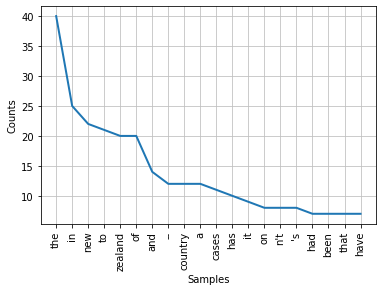

In [6]:
xurl="https://edition.cnn.com/2020/08/10/asia/new-zealand-coronavirus-milestone-intl-hnk-scli/index.html"
corptxt = MyCorporaArticle( xurl )
printCorpora( corptxt ) 

<class '__main__.MyCorporaTable'>
--- https://en.wikipedia ---
>> 14.0 Tinu Elejogun
25.0 Blaszczyk Kostrzewski
18.0
# sentences: 2
# words: 290
# vocab: 212
# lex diversity: 73.10%


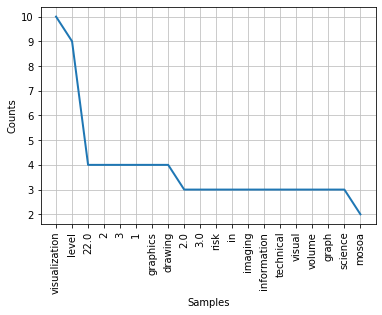

In [13]:
corptbl = MyCorporaTable("https://en.wikipedia.org/wiki/Table_(information)")
printCorpora(corptbl  , showtext=False)
#corptbl.text
#corptbl.dframe

<class '__main__.MyCorporaText'>
--- txt ---
>> The quick brown fox jumped over the lazy dogs! yes
# sentences: 3
# words: 13
# vocab: 11
# lex diversity: 84.62%

>>--- Sentences: ---
['The quick brown fox jumped over the lazy dogs!', 'yes, yes he did!', '!']

>>--- Words: --- 
['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dogs', 'yes', 'yes', 'he', 'did']

>>--- Vocab: ---
['brown', 'did', 'dogs', 'fox', 'he', 'jumped', 'lazy', 'over', 'quick', 'the', 'yes']

   the    yes  quick  brown    fox jumped   over   lazy   dogs     he    did 
     2      2      1      1      1      1      1      1      1      1      1 
>>--- FreqDist: ---
None



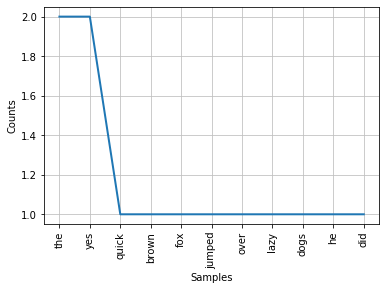

In [8]:
corptxt = MyCorporaText("The quick brown fox jumped over the lazy dogs! yes, yes he did!!" )
printCorpora( corptxt , showtext=True) 


In [9]:
encoder = TextEncoder( ngram_range=(1,1) )
encoder.encode_bow( corptxt.sentences )
printEncoder( encoder , showtext=False)

--- Encoder <class 'sklearn.feature_extraction.text.CountVectorizer'>--- 
--- ---
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None) 
--- Vocab size: 8--- 
--- Features size: 8--- 
--- Stopwords size: 318--- 
--- ---
  (0, 6)	1
  (0, 0)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 2)	1 


In [10]:
print(encoder.encoded_matrix)
print( encoder.encoded_matrix.toarray().shape )
encoder.encoded_matrix

  (0, 6)	1
  (0, 0)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 2)	1
  (1, 7)	2
  (1, 1)	1
(3, 8)


<3x8 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [11]:
print( encoder.encoder_features )#== 'yes, yes he did!'.split(' ')
print( encoder.encoder_vocab )


['brown', 'did', 'dogs', 'fox', 'jumped', 'lazy', 'quick', 'yes']
{'quick': 6, 'brown': 0, 'fox': 3, 'jumped': 4, 'lazy': 5, 'dogs': 2, 'yes': 7, 'did': 1}


In [12]:
encoder.transform(MyCorporaText('Holly cow! The dog ate the quick fox').sentences ).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0]])

# 2. Pipelines
Things 
- preprocessing, dimensionality reduction, 
- Custom transformers, models,, 
    - Keras/Tensor support
    - Pandas dataframes 
- parameter tuning, model selection, 
- reporting 

In [106]:
from sklearn import datasets

from sklearn.pipeline import Pipeline , FeatureUnion 
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import FunctionTransformer #, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


[0 1 0 1 0]
[1 0 2 2 2]
[0.9238095238095239, 0.9238095238095239, 0.9238095238095239, 0.9238095238095239, 0.9238095238095239]


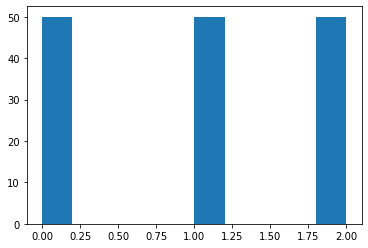

In [103]:
db = datasets.load_iris()
X = db.data
y = db.target
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=59)
y_baseline = [y_train.mean() ]*len( y_test ) 

print( y_train[:5] )

print( y_test[:5] )
print( y_baseline[:5] ) 

plt.hist( db.target ); 

In [104]:
pd.DataFrame.from_records( db.data ).describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [56]:
## Preprocessing
#   - Imputer, Quadratic, PolynomialFeatures, 
#
#######
## Transformers: fit, transform   << StandardScaler, MinMaxScaler, 
## Estimators: fit, predict       << LogisticRegression, 
#### 


In [92]:
# df = corptbl.dframe[ ['Age', 'First name', 'Last name']]
# df.dropna(inplace=True)
# df.info()
# df.isnull().sum()
# df['age_bins'].unique

# df['age_bins'] = pd.cut(df['Age'], bins=(2, 20, 103), labels=['young', 'mature'])
# age_lbl = LabelEncoder()
# df['maturity'] = age_lbl.fit_transform( df['age_bins'])
# df

# df['age_bins'].value_counts()
# plt.hist( df['age_bins'])

In [163]:
def run_with(pip2,name, y_base=y_baseline, logit=True):    
    # a. train 
    pip2.fit( X_train, y_train )
    # b. predict
    y_predz = pip2.predict(X_test)

    # c. results 
    if logit:
        print(f"\n\n{'='*10} {name.upper()} {'='*10}\n")
        print( f"Training accuracy: {pip2.score(X_train, y_train)}" )
        print( f"Test accuracy: {pip2.score(X_test, y_test)}" )
    #     print( f"--")
    #     print( f"Baseline Report\n{ classification_report(y_test, y_base)}")
        print( f"--")
        print( f"Classification Report\n{ classification_report(y_test, y_predz)}")
        print( f"--")
        print( f"Confuision Matrix\n{ confusion_matrix(y_test, y_predz)}")    
        #print(f"\n{'='*30}\n")
    return (pip2.score(X_train, y_train), pip2.score(X_test, y_test))

In [ ]:
modelz = [
    ('logit', LogisticRegression()),
    ('rfc', RandomForestClassifier(n_estimators=200) ),   ##small-med size data, smaller number of classes/bins
    ('svm', SVC() ) , ##  faster than random forest if larger raw data 
    ('dnn', MLPClassifier(
        hidden_layer_sizes=(11,11,11), max_iter=500
        ) ), # nlp, sequence/series data, tonnes of data, variety, images
]
     
acc= []
for i, model in enumerate(modelz):
     #('minmax', MinMaxScaler()),
    res = run_with ( Pipeline([
                    ('std', StandardScaler()),
                    model
                     ]) ,
                    
                    f"{i+1}. {model[0]}",
                    logit=False
             )
    acc.append( [model[0], *res] )
    
    
d = pd.DataFrame.from_records(acc)
d.columns = ['model', 'train_acc', 'test_acc']
d = pd.melt(d, id_vars=['model'], 
               value_vars=['train_acc', 'test_acc'], 
               var_name='acc', value_name='score')
# d
sns.lineplot(x='model', y='score', hue='acc',data=d)